In [32]:
from sklearn.datasets import fetch_olivetti_faces
import sys
import matplotlib.pyplot as plt
import numpy as np
import importlib
import pickle

In [33]:
def plot_image_grid(images, title, image_shape=(64,64),n_col=5, n_row=2, bycol=0, row_titles=None,col_titles=None):
    fig,axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(2. * n_col, 2.26 * n_row))
    for i, comp in enumerate(images):
        row,col = reversed(divmod(i,n_row)) if bycol else divmod(i,n_col)       
        cax = axes[row,col]
        cax.imshow(comp.reshape(image_shape), cmap='gray',
                   interpolation='nearest',
                   vmin=comp.min(), vmax=comp.max())
        cax.set_xticks(())
        cax.set_yticks(())
    if row_titles is not None :
        for ax,row in zip(axes[:,0],row_titles) :
            ax.set_ylabel(row,size='large')
    if col_titles is not None :
        for ax,col in zip(axes[0],col_titles) :
            ax.set_title(col)
    
    fig.suptitle(title)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(title + '.pdf',bbox_inches='tight')
    plt.show()

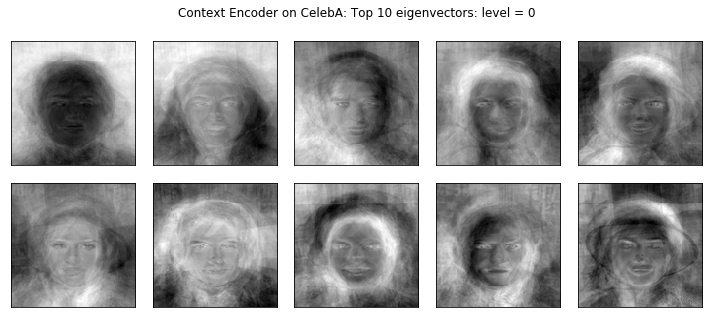

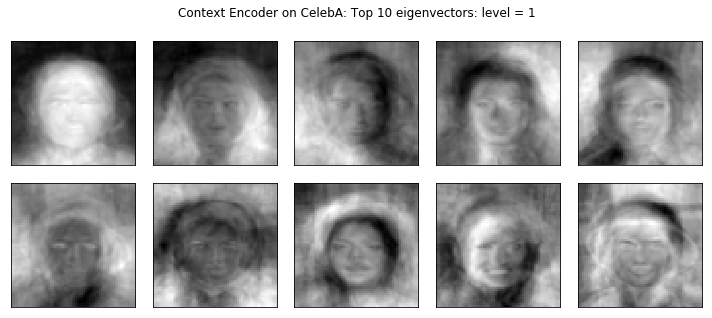

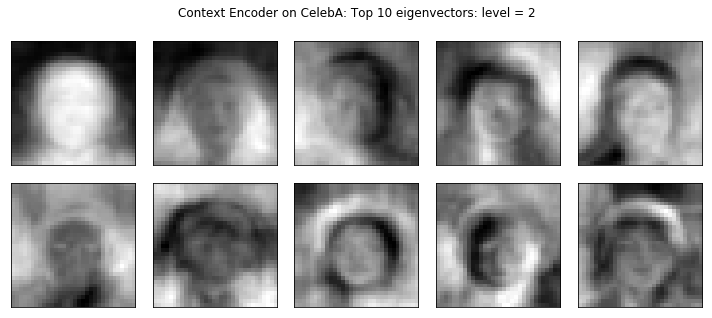

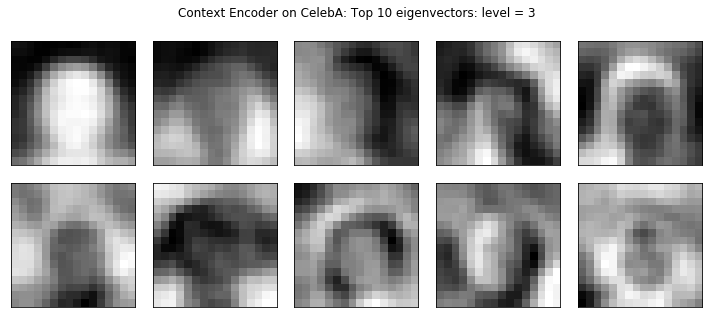

In [31]:
file='original_celebA_pyramids.p'
celebA_pyramid_eigvalvecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(celebA_pyramid_eigvalvecs):
    eig_vals = celebA_pyramid_eigvalvecs[level][0] 
    eig_vecs = celebA_pyramid_eigvalvecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


In [20]:
file='reconstructed_celebA_pyramids.p'
celebA_pyramid_eigvalvecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(celebA_pyramid_eigvalvecs):
    eig_vals = celebA_pyramid_eigvalvecs[level][0] 
    eig_vecs = celebA_pyramid_eigvalvecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


256

In [ ]:
file='cropped_original_celebA_pyramids.p'
celebA_pyramid_eigvalvecs=pickle.load(open(file),'rb'))
for level,_ in enumerate(celebA_pyramid_eigvalvecs):
    eig_vals = celebA_pyramid_eigvalvecs[level][0] 
    eig_vecs = celebA_pyramid_eigvalvecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)


In [ ]:
file='cropped_reconstructed_celebA_pyramids.p'
celebA_pyramid_eigvalvecs=pickle.load(open(file,'rb'))
for level,_ in enumerate(celebA_pyramid_eigvalvecs):
    eig_vals = celebA_pyramid_eigvalvecs[level][0] 
    eig_vecs = celebA_pyramid_eigvalvecs[level][1] 
    images = eig_vecs[-10:] 
    images = np.flipud(images)
    plot_title = 'Context Encoder on CelebA: ' + 'Top 10 eigenvectors: level = ' +str(level)
    plot_image_grid(images,plot_title ,image_shape=eig_vecs[0].shape)
